<a href="https://colab.research.google.com/github/vydiep/MLProject/blob/main/PT_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
files.upload()

Saving RNN_util.py to RNN_util.py


{'RNN_util.py': b'import json\nimport numpy as np\nfrom sklearn.model_selection import train_test_split\nimport time\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nimport matplotlib.pyplot as plt\nfrom torch.utils.data import DataLoader, TensorDataset\n\ndef load_data(data_path):\n    """\n    Load data from JSON file \n\n    :param  data_path(string)\n        Path to JSON file \n\n    :return X (ndarray)      \n        Features from data\n    :return y (ndarray)      \n        Label for data\n\n    Resource: \n        https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/19-%20How%20to%20implement%20an%20RNN-LSTM%20for%20music%20genre%20classification/code/19-%20How%20to%20implement%20an%20RNN-LSTM%20for%20music%20genre%20classification.py\n    """\n\n    with open(data_path, "r") as fp:\n        data = json.load(fp)\n\n    X = np.array(data["mfcc"])\n    y = np.array(data["labels"])\n    \n    return X, y\n\n\ndef prepare_datasets(data_path, 

In [3]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from RNN_util import get_data_loaders, train, test, plot_history
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torchinfo import summary

## LSTM Model (No Dropout)

In [5]:
"""
Gudiance from Resources: 
    https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_lstm_neuralnetwork/
    https://middlebury-csci-0451.github.io/CSCI-0451/lecture-notes/text-generation.html 
"""

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, layer_dim=2, output_dim=1):
        """
        Create LSTM Model with 1 hidden layer for binary classification 
        """
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.training_info = {'train_losses': [], 
                              'train_accuracies': [],
                              'val_losses': [], 
                              'val_accuracies': []}

        # LSTM Layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = out[:,-1,:]
        out = self.fc(relu(out))

        return out

## Data Loading/Prep

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DATA_PATH = "/content/drive/Shareddrives/MLProject/MusicNet/rnn-data.json"
train_loader, val_loader, test_loader = get_data_loaders(DATA_PATH)

## LSTM with 1 Layer

In [7]:
model_1_path = "/content/drive/Shareddrives/MLProject/MusicNet/models/LSTM-1-Layer.pth"
graph_1_path = "/content/drive/Shareddrives/MLProject/MusicNet/models/LSTM-1-Layer-graph.png"

In [8]:
model_1 = LSTMModel(input_dim=13, layer_dim=1)
# Load previously saved model for more training
# checkpoint = torch.load(model_1_path)
# model_1.load_state_dict(checkpoint['model_state_dict'])
# model_1.training_info['train_losses'] = checkpoint['train_losses']
# model_1.training_info['train_accuracies'] = checkpoint['train_accuracies']
# model_1.training_info['val_losses'] = checkpoint['val_losses']
# model_1.training_info['val_accuracies'] = checkpoint['val_accuracies']
# model_1.eval()
# model_1.training_info

In [9]:
summary(model_1)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              20,224
├─Linear: 1-2                            65
Total params: 20,289
Trainable params: 20,289
Non-trainable params: 0

In [29]:
train(model_1, train_loader, val_loader, 25, device)

Epoch 76:
	Train Loss=0.3638 Train Accuracy=82.32%
	Val Loss  =0.5149 Val Accuracy  =76.30%
Epoch 77:
	Train Loss=0.3438 Train Accuracy=84.12%
	Val Loss  =0.5199 Val Accuracy  =76.04%
Epoch 78:
	Train Loss=0.3478 Train Accuracy=83.46%
	Val Loss  =0.5166 Val Accuracy  =75.91%
Epoch 79:
	Train Loss=0.3425 Train Accuracy=83.93%
	Val Loss  =0.5072 Val Accuracy  =75.52%
Epoch 80:
	Train Loss=0.3449 Train Accuracy=83.55%
	Val Loss  =0.5297 Val Accuracy  =75.00%
Epoch 81:
	Train Loss=0.3404 Train Accuracy=83.78%
	Val Loss  =0.5122 Val Accuracy  =73.44%
Epoch 82:
	Train Loss=0.3399 Train Accuracy=84.06%
	Val Loss  =0.5088 Val Accuracy  =75.26%
Epoch 83:
	Train Loss=0.3350 Train Accuracy=84.25%
	Val Loss  =0.5123 Val Accuracy  =76.17%
Epoch 84:
	Train Loss=0.3410 Train Accuracy=84.53%
	Val Loss  =0.5432 Val Accuracy  =74.87%
Epoch 85:
	Train Loss=0.3481 Train Accuracy=83.87%
	Val Loss  =0.5196 Val Accuracy  =75.52%
Epoch 86:
	Train Loss=0.3307 Train Accuracy=84.22%
	Val Loss  =0.5209 Val Accura

In [30]:
test(model_1, test_loader, device) 

Test accuracy: 74 %


In [31]:
torch.save({
            'model_state_dict': model_1.state_dict(),
            'train_losses': model_1.training_info['train_losses'],
            'train_accuracies': model_1.training_info['train_accuracies'],
            'val_losses': model_1.training_info['val_losses'],
            'val_accuracies': model_1.training_info['val_accuracies']
            }, model_1_path)

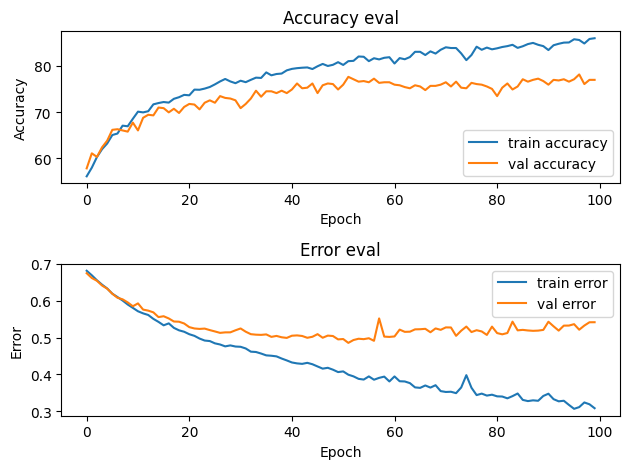

In [32]:
plot_history(model_1, graph_1_path)

## LSTM with 2 Layers

In [14]:
model_2_path = "/content/drive/Shareddrives/MLProject/MusicNet/models/LSTM-2-Layers.pth"
graph_2_path = "/content/drive/Shareddrives/MLProject/MusicNet/models/LSTM-2-Layers-graph.png"

In [15]:
model_2 = LSTMModel(input_dim=13, layer_dim=2)
# Load previously saved model for more training
# checkpoint = torch.load(model_2_path)
# model_2.load_state_dict(checkpoint['model_state_dict'])
# model_2.training_info['train_losses'] = checkpoint['train_losses']
# model_2.training_info['train_accuracies'] = checkpoint['train_accuracies']
# model_2.training_info['val_losses'] = checkpoint['val_losses']
# model_2.training_info['val_accuracies'] = checkpoint['val_accuracies']
# model_2.eval()
# model_2.training_info

In [16]:
summary(model_2)

Layer (type:depth-idx)                   Param #
LSTMModel                                --
├─LSTM: 1-1                              53,504
├─Linear: 1-2                            65
Total params: 53,569
Trainable params: 53,569
Non-trainable params: 0

In [33]:
train(model_2, train_loader, val_loader, 25, device)

Epoch 76:
	Train Loss=0.2683 Train Accuracy=87.97%
	Val Loss  =0.5230 Val Accuracy  =78.65%
Epoch 77:
	Train Loss=0.2632 Train Accuracy=88.70%
	Val Loss  =0.5805 Val Accuracy  =78.39%
Epoch 78:
	Train Loss=0.2719 Train Accuracy=88.19%
	Val Loss  =0.6579 Val Accuracy  =73.96%
Epoch 79:
	Train Loss=0.2794 Train Accuracy=87.91%
	Val Loss  =0.6351 Val Accuracy  =75.52%
Epoch 80:
	Train Loss=0.2532 Train Accuracy=88.89%
	Val Loss  =0.6533 Val Accuracy  =76.82%
Epoch 81:
	Train Loss=0.3030 Train Accuracy=86.65%
	Val Loss  =0.5476 Val Accuracy  =77.21%
Epoch 82:
	Train Loss=0.3631 Train Accuracy=83.30%
	Val Loss  =0.5219 Val Accuracy  =76.30%
Epoch 83:
	Train Loss=0.3090 Train Accuracy=86.21%
	Val Loss  =0.5561 Val Accuracy  =76.95%
Epoch 84:
	Train Loss=0.2749 Train Accuracy=88.45%
	Val Loss  =0.5139 Val Accuracy  =78.78%
Epoch 85:
	Train Loss=0.2575 Train Accuracy=89.17%
	Val Loss  =0.5391 Val Accuracy  =78.12%
Epoch 86:
	Train Loss=0.2433 Train Accuracy=89.61%
	Val Loss  =0.5628 Val Accura

In [34]:
test(model_2, test_loader, device) 

Test accuracy: 78 %


In [35]:
torch.save({
            'model_state_dict': model_2.state_dict(),
            'train_losses': model_2.training_info['train_losses'],
            'train_accuracies': model_2.training_info['train_accuracies'],
            'val_losses': model_2.training_info['val_losses'],
            'val_accuracies': model_2.training_info['val_accuracies']
            }, model_2_path)

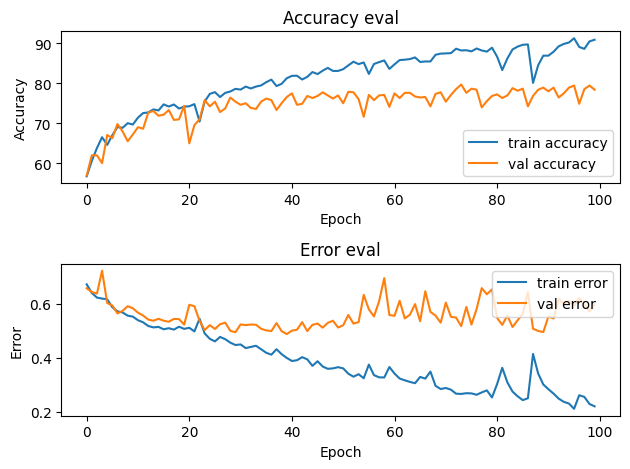

In [36]:
plot_history(model_2, graph_2_path)